# Import libraries

In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
import re

# Load Dataset

In [18]:
df = pd.read_csv("Reviews.csv",index_col=0)

In [19]:
df.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Id,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [20]:
# Retain only the columns to be used for training
df["review"] = df["Score"].apply(lambda x: 0 if x<4 else 1)
df = df[["Text","review"]]

# Preprocessing

Firstly we will be filtering all the common words like 'a', 'the', 'an' etc. This is achieved by the stop words provided by the nltk library

In [21]:
stop_words = stopwords.words('english')

def filter_stop_words(text):
    text = re.sub(r'\d+', ' ', text)
    #text = text.split()
    #text = " ".join([word for word in text if word.lower().strip() not in stop_words])
    #text = " ".join([word for word in text])
    return text

In [22]:
df["Text"] = df["Text"].apply(lambda x: filter_stop_words(x))
df

,Text,review
Id,,
1,I have bought several of the Vitality canned d...,1
2,Product arrived labeled as Jumbo Salted Peanut...,0
3,This is a confection that has been around a fe...,1
4,If you are looking for the secret ingredient i...,0
5,Great taffy at a great price. There was a wid...,1
...,...,...
568450,Great for sesame chicken..this is a good if no...,1
568451,I'm disappointed with the flavor. The chocolat...,0
568452,"These stars are small, so you can give - of ...",1


### Balancing Training data

The dataset has almost 4 times the positive reviews compared to negative reviews. To counter this we can sample only a part of the positive reviews

In [23]:
df["review"].value_counts() # 1 for positive and 0 for negative

1    443777
0    124677
Name: review, dtype: int64

In [24]:
positive_reviews = df[df.review == 1]
negative_reviews = df[df.review == 0]

positive_reviews = positive_reviews.sample(n=len(negative_reviews)) # sample positive examples whose number is equal to the negative examples

df = positive_reviews.append(negative_reviews).reset_index(drop=True)

In [25]:
df
# The data is not shuffled right now, but it can be shuffled once we call the train test split function

,Text,review
0,Looked for something other than chocolate and ...,1
1,I love this product. I add it to protein/whey/...,1
2,Great tasting coffee. Exactly the flavor it sa...,1
3,"I have had the watermelon, mango, blue raspber...",1
4,Gracie (our miniature Dachshund) absolutely lo...,1
...,...,...
249349,I just bought this soup today at my local groc...,0
249350,This soup is mostly broth. Although it has a k...,0
249351,"It is mostly broth, with the advertised / cu...",0
249352,I had ordered some of these a few months back ...,0


In [26]:
sentences = df["Text"].values
labels = df["review"].values

In [27]:
# Define training and testing sets
train_sentences,test_sentences,train_labels,test_labels = train_test_split(sentences,labels,test_size=0.3,shuffle=True)

In [28]:
del positive_reviews,negative_reviews,sentences,labels

# Tokenization

In [35]:
embed_dim = 64 # dimension of the embedding layer
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
vocab_size = 10000
max_length = 500

In [36]:
tokenizer = Tokenizer(num_words=vocab_size,oov_token=oov_tok) #Define tokenizer
tokenizer.fit_on_texts(train_sentences) # Assign tokens based on words on training set

train_sequences = tokenizer.texts_to_sequences(train_sentences) # Create sequences based on tokens for the training set

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type) # pad/truncate zeros at the end for a length of 'max_length' 


test_sequences = tokenizer.texts_to_sequences(test_sentences) # similar preprocessing for test set
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Define Model

In [39]:
regularizer = tf.keras.regularizers.l2(l2=0.001)
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embed_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,kernel_regularizer = regularizer)),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu',kernel_regularizer = regularizer),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8,activation='relu',kernel_regularizer=regularizer),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid',kernel_regularizer = regularizer)
])
optimizer = tf.keras.optimizers.Adam()
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 64)           640000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                24832     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0

In [40]:
history = model.fit(train_padded, train_labels, epochs=15, validation_data=(test_padded, test_labels),batch_size=128)

Epoch 1/15
1364/1364 [==============================] - 69s 51ms/step - loss: 0.4328 - accuracy: 0.8304 - val_loss: 0.3411 - val_accuracy: 0.8732
Epoch 2/15
1364/1364 [==============================] - 69s 50ms/step - loss: 0.3308 - accuracy: 0.8825 - val_loss: 0.3224 - val_accuracy: 0.8788
Epoch 3/15
1364/1364 [==============================] - 68s 50ms/step - loss: 0.2991 - accuracy: 0.8965 - val_loss: 0.3036 - val_accuracy: 0.8882
Epoch 4/15
1364/1364 [==============================] - 69s 50ms/step - loss: 0.2711 - accuracy: 0.9096 - val_loss: 0.2857 - val_accuracy: 0.8948
Epoch 5/15
1364/1364 [==============================] - 68s 50ms/step - loss: 0.2522 - accuracy: 0.9181 - val_loss: 0.2799 - val_accuracy: 0.8998
Epoch 6/15
1364/1364 [==============================] - 69s 51ms/step - loss: 0.2338 - accuracy: 0.9252 - val_loss: 0.2818 - val_accuracy: 0.8996
Epoch 7/15
1364/1364 [==============================] - 68s 50ms/step - loss: 0.2179 - accuracy: 0.9318 - val_loss: 0.2821 -

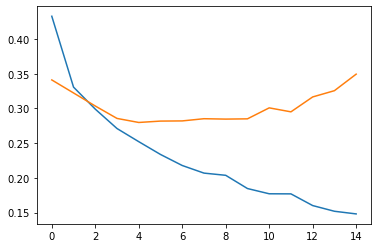

In [41]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

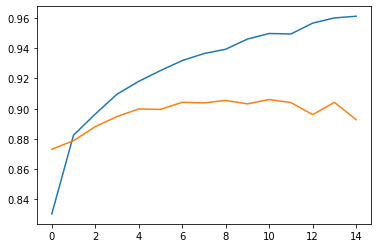

In [42]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

# Get embedding vectors

In [43]:
word_index = tokenizer.word_index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [44]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(10000, 64)


In [45]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

# Predict using custom string

In [61]:
test_string = ["horrible food, bitter food, really bad,bad bad bad bad bad bad bad bad bad bad "]

In [62]:
test_token = tokenizer.texts_to_sequences(np.array(test_string))

In [63]:
test_token

[[631, 53, 342, 53, 66, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138]]

In [64]:
string_padded = pad_sequences(test_token, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [65]:
model.predict(string_padded)

array([[0.00103716]], dtype=float32)